# Assignment 8

In [36]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [45]:
# inputs for idea gas law
temp = 298 #K
pres = 1e5 #Pa
Rgas = 8.134 #J/(mol-K)
avo = 6.022e23

In [241]:
# create meshgrid for NOx and RH values as coordinates for contour map
nox_list = np.arange(0,51,5) #ppbv # range is 0-50
rh_list = np.arange(50,501,50) #ppbv #range is 50-500
PHOx = 0.1 #pptv/s

In [242]:
NOx, RH = np.meshgrid(nox_list, rh_list)
print(NOx)
print(RH)

[[ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]
 [ 0  5 10 15 20 25 30 35 40 45 50]]
[[ 50  50  50  50  50  50  50  50  50  50  50]
 [100 100 100 100 100 100 100 100 100 100 100]
 [150 150 150 150 150 150 150 150 150 150 150]
 [200 200 200 200 200 200 200 200 200 200 200]
 [250 250 250 250 250 250 250 250 250 250 250]
 [300 300 300 300 300 300 300 300 300 300 300]
 [350 350 350 350 350 350 350 350 350 350 350]
 [400 400 400 400 400 400 400 400 400 400 400]
 [450 450 450 450 450 450 450 450 450 450 450]
 [500 500 500 500 500 500 500 500 500 500 500]]


In [200]:
# rate constants for each gas species (eg. VOCs) at 298K, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # units s-1
k8 = 1.9e-14

In [237]:
#unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #air density, converted to mol/cm3 #concentration of all species in the atmosphere
CNOx = NOx*1e-9*airden #concentration of NOx in mol/cm3
CRH = RH*1e-9*airden #concenrtation of RH in mol/cm3
CPHOx = PHOx*1e-12*airden #concentration of PHOx in mol/cm3, it's 1e-12 because the original unit is parts per trillian

#create a factor that can easily convert concentration in molecules/cm3 to ppb
ppbfac = 1e9/airden

In [202]:
# set function for ozone formation

# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH
def myfun(t,u):
    f = np.zeros(7)
    f[0] = -k2*u[3]*u[0] + k7*u[1] - k8*u[5]*u[0] - k3*u[4]*u[0] # rate of NO change
    f[1] = k2*u[3]*u[0] + k3*u[4]*u[0] + k8*u[5]*u[0] - k7*u[1] - k4*u[2]*u[1]
    f[2] = -k1*u[6]*u[2] + k3*u[4]*u[0] - k4*u[2]*u[1] + CPHOx 
    f[3] = k1*u[6]*u[2] - k2*u[3]*u[0] - k6*u[3]*u[4]
    f[4] = k2*u[3]*u[0] - k3*u[4]*u[0] - 2*k5*u[4]**2 - k6*u[3]*u[4] #twice HO2 is in reactants
    f[5] = k7*u[1] - k8*u[5]*u[0]
    f[6] = -k1*u[6]*u[2]
    return f

In [243]:
# Create an empty max_ozone matrix
max_ozone = np.zeros_like(NOx)

In [248]:
# Loop over each combination of initial NOx and RH
for i in range(NOx.shape[0]):
    for j in range(NOx.shape[1]):
        u0 = np.zeros(7)  # Initialize the concentrations of all species to zero
        u0[0] = CNOx[i, j]*2/3  # Initial NO concentration
        u0[1] = CNOx[i, j]*1/3  # Initial NO2 concentration
        u0[2] = 0
        u0[3] = 0
        u0[4] = 0
        u0[5] = 0
        u0[6] = CRH[i, j]
        sol = solve_ivp(myfun, [t0, tmax], u0, method='LSODA', t_eval=t)
        max_ozone[i, j] = np.max(sol.y[5]*ppbfac)

In [249]:
# Timestep: changed to a larger Dt than from class to save computational time (doesn't really affect final output accuracy)
Dt = 360 #seconds
t0 = 0
tmax = 96*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

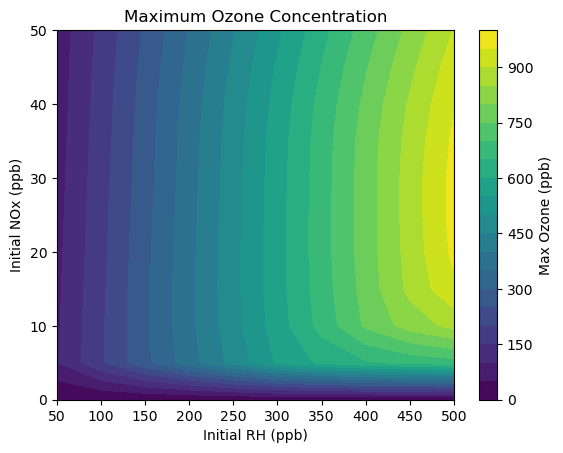

In [251]:
plt.contourf(RH, NOx, max_ozone, levels=20, cmap='viridis')
plt.xlabel('Initial RH (ppb)')
plt.ylabel('Initial NOx (ppb)')
plt.title('Maximum Ozone Concentration')
plt.colorbar(label='Max Ozone (ppb)')